In [2]:
import os
import warnings

import pandas as pd
import numpy as np


from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)

In [4]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city["1101"]}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area["1100"]}") 

# In the future, we may want to use the 175 sub cities and just skip this
# Problem currently is that we don't have taxable income for sub cities
def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [6]:
area_code = 7344
prefecture_code = area_code // 1000
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in sorted(os.listdir(trade_prices_data_path))
]
trade_prices_data_paths[prefecture_code - 1]

'../../data/core/07_Fukushima Prefecture_20053_20232.csv'

In [8]:
df = pd.read_csv(trade_prices_data_paths[prefecture_code - 1], encoding="unicode_escape", index_col="No")
df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

# we may want to skip the following step in the future
df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
df["area"] = df["area_code"].apply(get_area_from_area_code)

df["trade_price"] = df["Transaction-price(total)"]
df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
df["unit_price"] = df["Transaction-price(Unit price m^2)"]
df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

df["unit_price"] = np.where(
    df["unit_price"].isna(),
    df["trade_price_per_area"],
    df["unit_price"],
)

# Only buildings df for now
df = df[df["Type"] == asset_types["land"]["label"]]


In [9]:
df["Type"].value_counts()

Type
Residential Land(Land Only)    35869
Name: count, dtype: int64

In [13]:
columns = ["Type", "Region", "Area", "Transaction-price(total)", "Area(m^2)", "Nearest stationFDistance(minute)", "Use", "Purpose of Use", "Frontage roadFClassification", "Transaction period", "year", "unit_price"]
area_df = df[(df["City,Town,Ward,Village code"] == area_code)]
area_df[area_df["year"].isin(list(range(2008, 2013)))].sort_values(by=["year", "quarter"])[columns]


,Type,Region,Area,Transaction-price(total),Area(m^2),Nearest stationFDistance(minute),Use,Purpose of Use,Frontage roadFClassification,Transaction period,year,unit_price
No,,,,,,,,,,,,
75144,Residential Land(Land Only),Residential Area,Oaza Tarao,200000,1100,2H-,NaN,NaN,Private Road,2nd quarter 2008,2008,180.0
75146,Residential Land(Land Only),Residential Area,Oaza Tarao,500000,380,2H-,NaN,NaN,Private Road,2nd quarter 2008,2008,1300.0
75148,Residential Land(Land Only),Residential Area,Oaza Tarao,1800000,560,2H-,NaN,NaN,Private Road,2nd quarter 2008,2008,3200.0
75150,Residential Land(Land Only),Residential Area,Oaza Tarao,600000,1100,2H-,NaN,NaN,Private Road,2nd quarter 2008,2008,530.0
75153,Residential Land(Land Only),Residential Area,Oaza Tarao,500000,600,2H-,NaN,NaN,Private Road,2nd quarter 2008,2008,830.0
75077,Residential Land(Land Only),Residential Area,Oaza Iitoyo,8300000,300,2H-,NaN,NaN,Private Road,3rd quarter 2008,2008,28000.0
75133,Residential Land(Land Only),Residential Area,Oaza Tarao,200000,1300,2H-,NaN,NaN,Private Road,3rd quarter 2008,2008,150.0
75136,Residential Land(Land Only),Residential Area,Oaza Tarao,390000,440,2H-,NaN,NaN,Private Road,3rd quarter 2008,2008,890.0
75137,Residential Land(Land Only),Residential Area,Oaza Tarao,1600000,490,2H-,NaN,NaN,Private Road,3rd quarter 2008,2008,3300.0


In [17]:
area_df.groupby("year").agg({"unit_price": "median"})

,unit_price
year,
2005,288311.688312
2006,320000.000000
2007,269617.893756
2008,308101.851852
2009,280000.000000
2010,290909.090909
2011,269696.969697
2012,292058.823529
2013,266666.666667


<Axes: xlabel='year'>

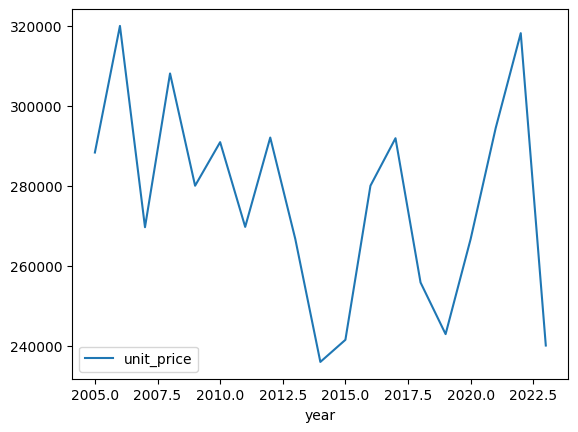

In [18]:
# Pre Heuristic
area_df.groupby("year").agg({"unit_price": "median"}).plot()


<Axes: xlabel='year'>

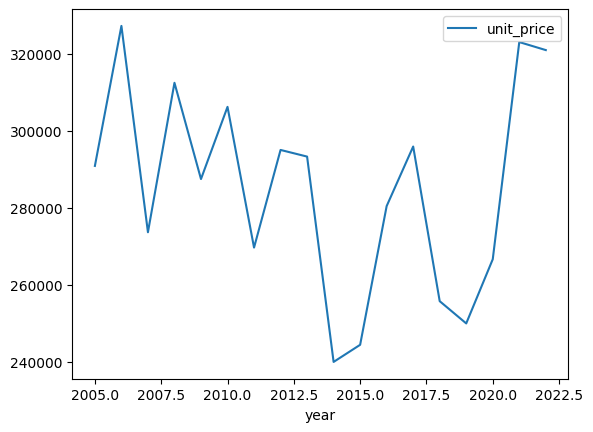

In [19]:
# Post Heuristic
new_area_df = area_df[area_df["year"] <= 2022]
new_area_df = new_area_df[
    (new_area_df["Region"] != "Industrial Area") &
    (~new_area_df["Use"].str.contains("Factory|Warehouse|Parking Lot", na=False, regex=True)) &
    (~new_area_df["Purpose of Use"].str.contains("Factory|Warehouse|Parking Lot", na=False, regex=True))
]

new_area_df.groupby("year").agg({"unit_price": "median"}).plot()


In [20]:
area_codes_used = [
    "7547", # industrial area issue # Fukushima issue
    "7545", # industrial area issue # Fukushima issue
    "7543", # industrial area issue # Fukushima issue
    "34203" # industrial area issue
    "37322", # weighted median issue
    "1608", # No obvious heuristics. raw data is janky.
    "10429", 
    "10429", # signals in data. Can't really complain
    "10345", # signals in data. Can't really complain
    "16209", # industrial area issue
    "36206"
]
"""
Heurisitics:
(df["Region"] != "Industrial Area") &
(not df["Use"].str.contains( any of ["Factory", "Warehouse", "Parking Lot"])
(not df["Purpose of Use"].str.contains(["Factory", "Warehouse", "Parking Lot"])

Remove edge cases with years with only one count. Edges are harder to smooth.
Remove 2023. Partial data is just noise.
Add count as a smoothing parameter. // Maybe unnecessary
"""




'\nHeurisitics:\n(df["Region"] != "Industrial Area") &\n(not df["Use"].str.contains( any of ["Factory", "Warehouse", "Parking Lot"])\n(not df["Purpose of Use"].str.contains(["Factory", "Warehouse", "Parking Lot"])\n\nRemove edge cases with years with only one count. Edges are harder to smooth.\nRemove 2023. Partial data is just noise.\nAdd count as a smoothing parameter. // Maybe unnecessary\n'

In [21]:
"""
Fixed this bizarre bug with the transaction year code. Lesson, keep dataframe operations simple.
Area Weighted puts too much weight into transactions that have 2000 m^2 or greater. Use median.
"""

'\nFixed this bizarre bug with the transaction year code. Lesson, keep dataframe operations simple.\nArea Weighted puts too much weight into transactions that have 2000 m^2 or greater. Use median.\n'

In [22]:
# df[(df["Region"] == "Residential Area") & (df["Area(m^2)"] == "2,000 m^2 or greater.")]


In [23]:
"""
I may need to define a bit more involved logic and steps to determine when to include a transaction and when to discard it
For example, the industrial area case with the 2000 m^2 or greater area is to be thrown away.
However, this does necessarily not mean I should throw away all transactions with 2000 m^2 or greater area.
Some are for housing complexes and may include valid signals as the prices, while discounted, should be reflective of the market's opinion.
As such, I should dive deep into the intricacies of this dataset and try to understand its nuances
The input dataset is of the utmost importance
"""

"""
Task: Filter out undesirable transactions
Fitering post smoothing is less meaningful. The undesirable transactions impact the nearby ones.
Filtering out years after aggregation is wasteful.
Figure out heuristics to filter out anomalies. This is a form of smoothing.
The only filtering we do should be done with transactions. We don't filter our years.
Years will be frontfilled and smoothed.
Set count = 0 for all frontfilled values.
"""

"""
Task: Filter out undesirable transactions

1. Identify the municipalities and years that we filtered out in the dataset building notebook.
2. Go into the transactions to figure out what caused them to be anomalies. Then, figure out patterns in those anomalies.
3. Use those patterns to generate a heuristic.

Repeat steps 1, 2 and 3 until we no longer feel the need to filter out transactions.
This could be a multi-day process.
"""

'\nTask: Filter out undesirable transactions\n\n1. Identify the municipalities and years that we filtered out in the dataset building notebook.\n2. Go into the transactions to figure out what caused them to be anomalies. Then, figure out patterns in those anomalies.\n3. Use those patterns to generate a heuristic.\n\nRepeat steps 1, 2 and 3 until we no longer feel the need to filter out transactions.\nThis could be a multi-day process.\n'

In [24]:
# Oh shit, we are leaving behind a lot of data in pre-owned condominiums
df["Type"].value_counts()

Type
Residential Land(Land and Building)    53592
Name: count, dtype: int64

In [25]:
# correlation between returns of each segment
# remove because some years might have only warehouses whereas others have only houses for low count areas

df["Purpose of Use"].value_counts()

#

Purpose of Use
House        21363
Other         2476
Shop           819
Office         660
Warehouse      492
Factory        198
Name: count, dtype: int64

In [26]:
df["Use"].value_counts()

Use
House                                              41909
Housing Complex                                     1616
House, Shop                                         1392
Shop                                                1217
House, Parking Lot                                   564
                                                   ...  
House, Workshop, Warehouse, Shop                       1
Housing Complex, Factory                               1
House, Factory, Office, Warehouse, Shop                1
Housing Complex, Office, Warehouse, Shop, Other        1
Workshop, Shop, Other                                  1
Name: count, Length: 136, dtype: int64

In [27]:
# Once we've decided on a Area Code, we can drill down to City Planning to identify the type of zone we want to invest in
# Same for Use
df["City Planning"].value_counts()

City Planning
Category I Exclusively Low-story Residential Zone       14098
Category I Residential Zone                             12029
Category I Exclusively Medium-high Residential Zone      7547
Quasi-industrial Zone                                    5417
Neighborhood Commercial Zone                             2614
Commercial Zone                                          2604
Category II Residential Zone                             1971
Outside City Planning Area                               1656
Category II Exclusively Medium-high Residential Zone     1607
Industrial Zone                                          1458
Urbanization Control Area                                1257
Non-divided City Planning Area                            719
Quasi-residential Zone                                    293
Category II Exclusively Low-story Residential Zone        166
Exclusively Industrial Zone                                95
Quasi-city Planning Area                                

In [28]:
df["Frontage roadFClassification"].value_counts()

Frontage roadFClassification
City Road                        32641
Private Road                     13817
Kyoto/ Osaka Prefectural Road     2315
Road                              1920
Town Road                         1563
National Road                      649
Access Road                        230
Village Road                        62
Agricultural Road                   27
Prefectural Road                    17
Ward Road                           16
Forest Road                         10
Hokkaido Prefectural Road            4
Tokyo Metropolitan Road              1
Name: count, dtype: int64

In [29]:
# Price by class 
# classification = "Frontage roadFClassification"
classification = "Use"
pd.DataFrame(df.groupby(classification)["unit_price"].mean().sort_values(ascending=False))

,unit_price
Use,
"Office, Workshop, Warehouse, Parking Lot",4.921739e+06
"Housing Complex, Office, Parking Lot, Other",1.794872e+06
"Office, Shop, Other",1.260870e+06
"Housing Complex, Office, Other",1.198779e+06
"Office, Shop",1.040226e+06
...,...
"House, Workshop, Parking Lot, Other",3.043478e+03
"Factory, Warehouse, Other",2.166667e+03
"House, Factory, Warehouse, Other",1.750000e+03


In [30]:
# split into Purpose of Use
# Frontfill each and smooth to get a consistent chart
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53592 entries, 2 to 103993
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Type                                53592 non-null  object 
 1   Region                              53592 non-null  object 
 2   City,Town,Ward,Village code         53592 non-null  int64  
 3   Prefecture                          53592 non-null  object 
 4   City,Town,Ward,Village              53592 non-null  object 
 5   Area                                53565 non-null  object 
 6   Nearest stationFName               53500 non-null  object 
 7   Nearest stationFDistance(minute)   53422 non-null  object 
 8   Transaction-price(total)            53592 non-null  int64  
 9   Layout                              0 non-null      object 
 10  Area(m^2)                           53592 non-null  object 
 11  Transaction-price(Unit price m^2)   0 non-nul

In [31]:
# We can use transac